# Multivariate Analysis with Cars Dataset

This notebook demonstrates multivariate analysis using the cars dataset from vega-datasets.

We'll treat:
- **Observations**: Individual car models
- **Variables**: Performance and specification metrics
- **Groups**: Origin (USA, Europe, Japan)

In [1]:
# Import required libraries
import nuee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vega_datasets import data

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load and Prepare Data

In [2]:
# Load cars dataset
cars_df = data.cars()
print(f"Dataset shape: {cars_df.shape}")
print(f"\nColumns: {list(cars_df.columns)}")
print(f"\nFirst few rows:")
cars_df.head()

Dataset shape: (406, 9)

Columns: ['Name', 'Miles_per_Gallon', 'Cylinders', 'Displacement', 'Horsepower', 'Weight_in_lbs', 'Acceleration', 'Year', 'Origin']

First few rows:


,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,1970-01-01,USA
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,1970-01-01,USA
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,1970-01-01,USA
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,1970-01-01,USA
4,ford torino,17.0,8,302.0,140.0,3449,10.5,1970-01-01,USA


In [3]:
# Check for missing values and basic statistics
print("Missing values:")
print(cars_df.isnull().sum())
print(f"\nOrigin distribution:")
print(cars_df['Origin'].value_counts())

Missing values:
Name                0
Miles_per_Gallon    8
Cylinders           0
Displacement        0
Horsepower          6
Weight_in_lbs       0
Acceleration        0
Year                0
Origin              0
dtype: int64

Origin distribution:
Origin
USA       254
Japan      79
Europe     73
Name: count, dtype: int64


In [4]:
# Clean and prepare data
# Remove rows with missing values
cars_clean = cars_df.dropna()

# Select numeric columns for analysis
numeric_cols = ['Miles_per_Gallon', 'Cylinders', 'Displacement', 
                'Horsepower', 'Weight_in_lbs', 'Acceleration']
cars_numeric = cars_clean[numeric_cols]

# Store grouping variable
origin_groups = cars_clean['Origin']

print(f"Clean dataset shape: {cars_clean.shape}")
print(f"\nNumeric data shape: {cars_numeric.shape}")
cars_numeric.describe()

Clean dataset shape: (392, 9)

Numeric data shape: (392, 6)


,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000


## Exploratory Data Analysis

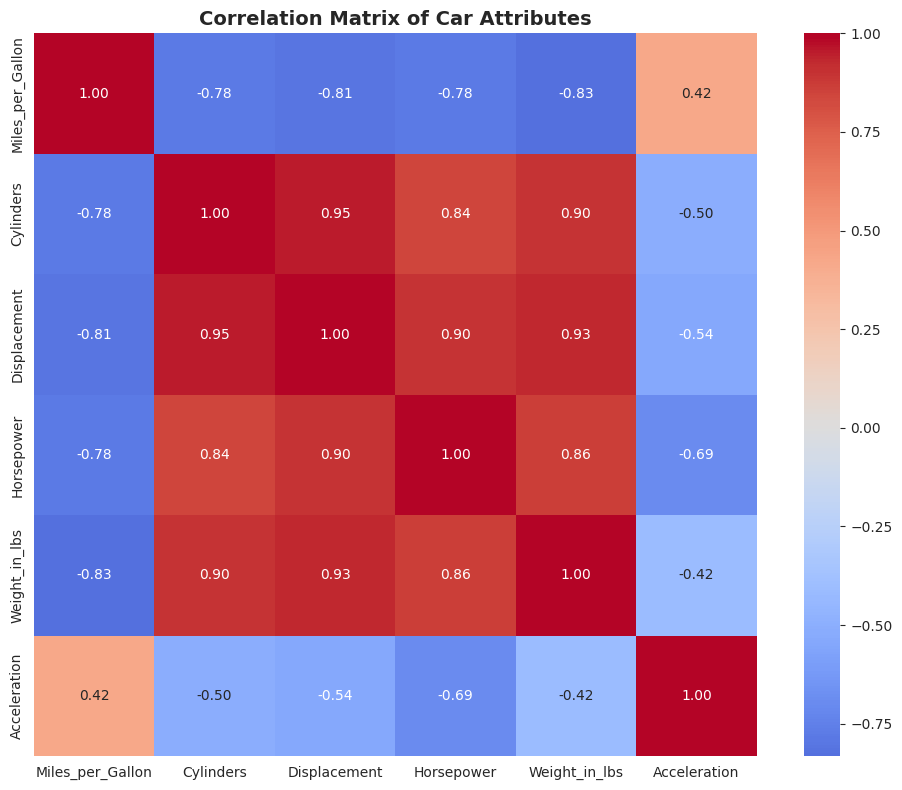

In [5]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
correlation = cars_numeric.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax)
ax.set_title('Correlation Matrix of Car Attributes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Principal Component Analysis (PCA)

In [6]:
# Perform PCA
pca_result = nuee.pca(cars_numeric)

# Get variance explained
var_explained = pca_result.eigenvalues / pca_result.eigenvalues.sum() * 100
cumvar_explained = np.cumsum(var_explained)

print("Variance explained by each component:")
for i, (var, cumvar) in enumerate(zip(var_explained[:4], cumvar_explained[:4])):
    print(f"PC{i+1}: {var:.2f}% (Cumulative: {cumvar:.2f}%)")

Variance explained by each component:
PC1: 79.80% (Cumulative: 79.80%)
PC2: 12.14% (Cumulative: 91.95%)
PC3: 4.31% (Cumulative: 96.26%)
PC4: 2.09% (Cumulative: 98.34%)


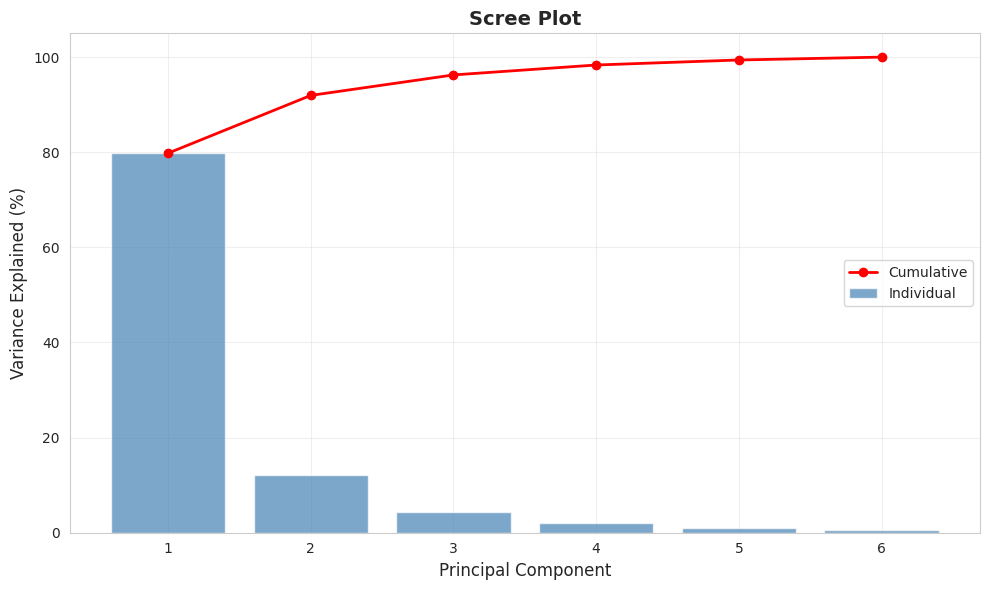

In [7]:
# Scree plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(1, len(var_explained)+1), var_explained, alpha=0.7, color='steelblue')
ax.plot(range(1, len(cumvar_explained)+1), cumvar_explained, 'ro-', linewidth=2)
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Variance Explained (%)', fontsize=12)
ax.set_title('Scree Plot', fontsize=14, fontweight='bold')
ax.legend(['Cumulative', 'Individual'], loc='right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

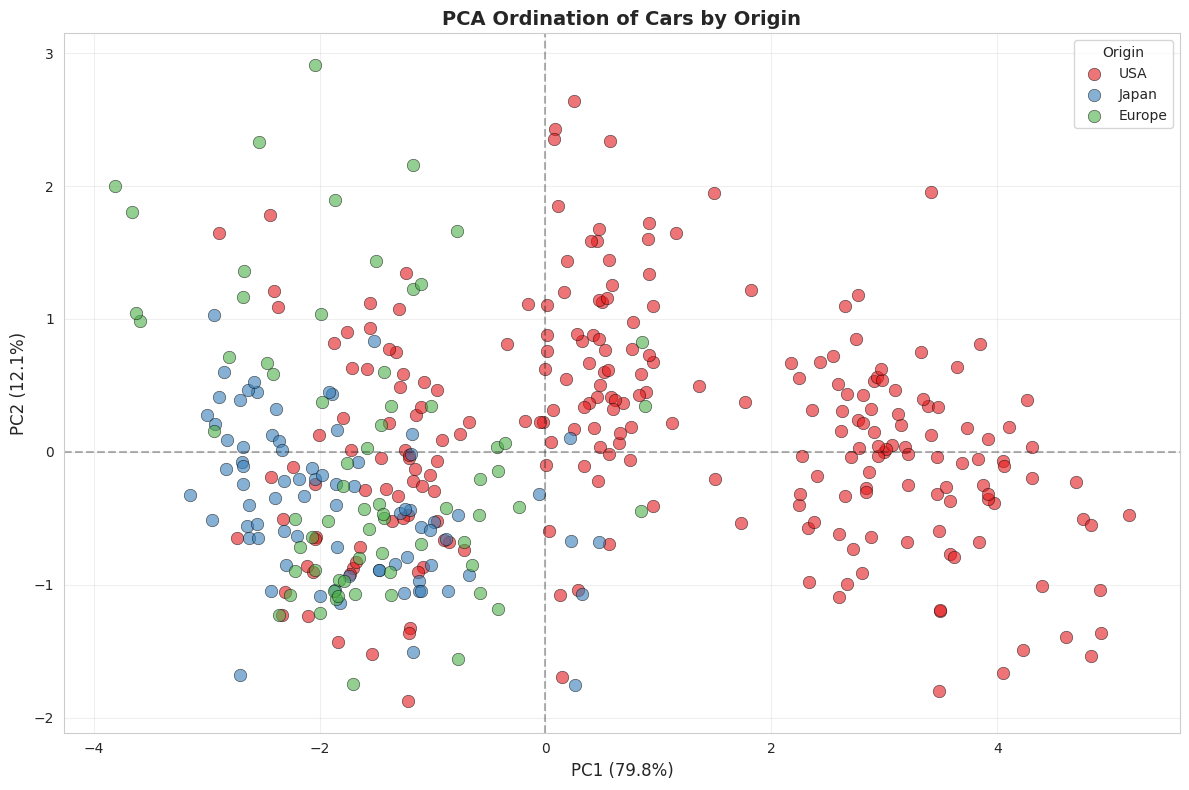

In [8]:
# Extract PCA scores
pca_scores = pd.DataFrame(
    pca_result.points[:, :2],
    columns=['PC1', 'PC2'],
    index=cars_numeric.index
)
pca_scores['Origin'] = origin_groups.values

# Plot PCA ordination colored by origin
fig, ax = plt.subplots(figsize=(12, 8))

origins = pca_scores['Origin'].unique()
colors = sns.color_palette('Set1', n_colors=len(origins))

for origin, color in zip(origins, colors):
    subset = pca_scores[pca_scores['Origin'] == origin]
    ax.scatter(subset['PC1'], subset['PC2'], 
               label=origin, alpha=0.6, s=80, color=color, edgecolors='black', linewidth=0.5)

ax.set_xlabel(f'PC1 ({var_explained[0]:.1f}%)', fontsize=12)
ax.set_ylabel(f'PC2 ({var_explained[1]:.1f}%)', fontsize=12)
ax.set_title('PCA Ordination of Cars by Origin', fontsize=14, fontweight='bold')
ax.legend(title='Origin', fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## PCA Biplot with Variable Loadings

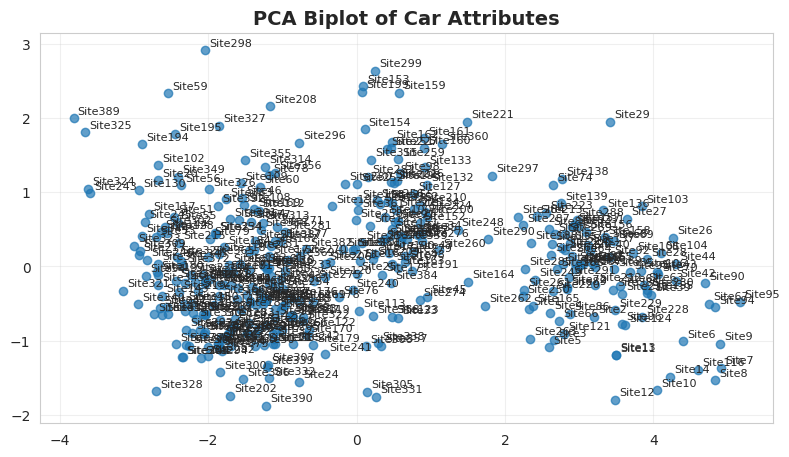

In [9]:
# Create biplot
fig = nuee.biplot(pca_result)
plt.title('PCA Biplot of Car Attributes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## NMDS Ordination

In [10]:
# Standardize data for NMDS
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cars_scaled = pd.DataFrame(
    scaler.fit_transform(cars_numeric),
    columns=cars_numeric.columns,
    index=cars_numeric.index
)

# Make all values positive for distance calculation
cars_positive = cars_scaled - cars_scaled.min().min() + 0.1

# Perform NMDS
nmds_result = nuee.metaMDS(cars_positive, k=2, distance='euclidean', trymax=50, trace=True)
print(f"\nNMDS Stress: {nmds_result.stress:.4f}")
print(f"Converged: {nmds_result.converged}")

Applying square root transformation


NMDS stress: 0.6348
NMDS converged

NMDS Stress: 0.6348
Converged: True


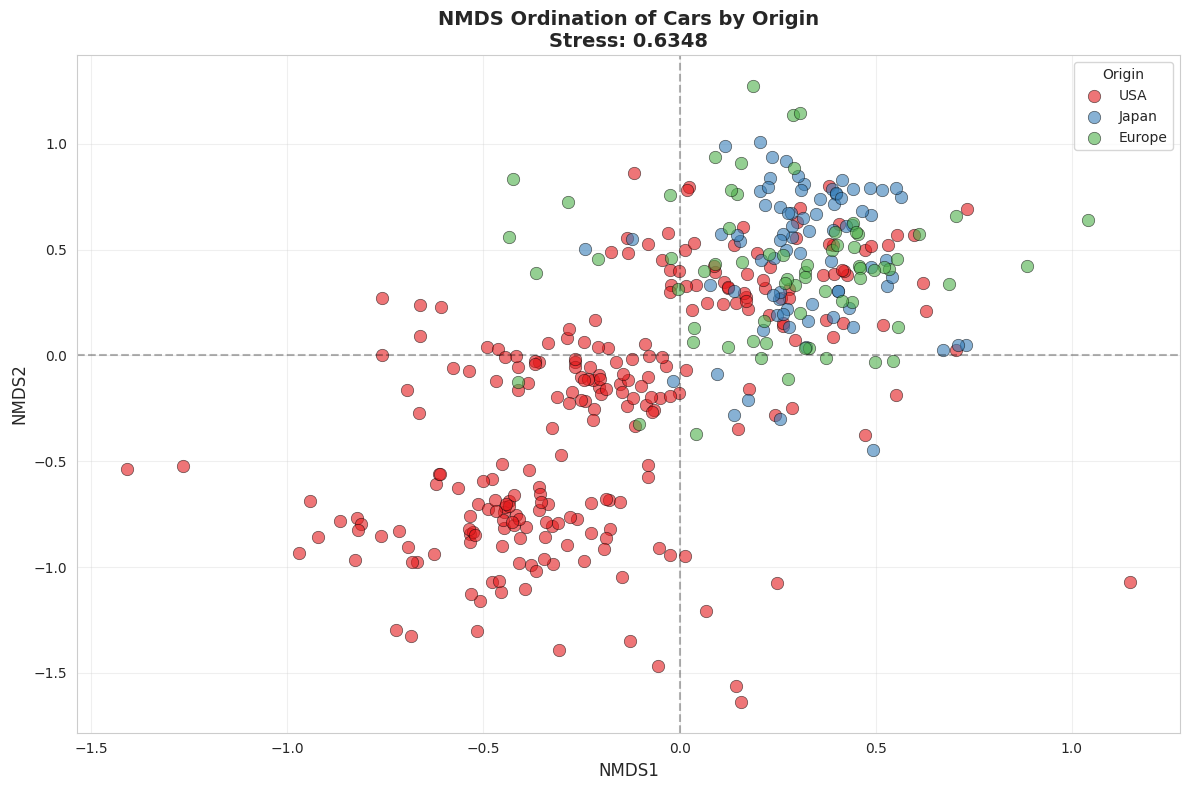

In [11]:
# Extract NMDS scores
nmds_scores = pd.DataFrame(
    nmds_result.points,
    columns=['NMDS1', 'NMDS2'],
    index=cars_numeric.index
)
nmds_scores['Origin'] = origin_groups.values

# Plot NMDS ordination
fig, ax = plt.subplots(figsize=(12, 8))

for origin, color in zip(origins, colors):
    subset = nmds_scores[nmds_scores['Origin'] == origin]
    ax.scatter(subset['NMDS1'], subset['NMDS2'], 
               label=origin, alpha=0.6, s=80, color=color, edgecolors='black', linewidth=0.5)

ax.set_xlabel('NMDS1', fontsize=12)
ax.set_ylabel('NMDS2', fontsize=12)
ax.set_title(f'NMDS Ordination of Cars by Origin\nStress: {nmds_result.stress:.4f}',
             fontsize=14, fontweight='bold')
ax.legend(title='Origin', fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## PERMANOVA Test

Test if car attributes differ significantly between origins.

In [12]:
# Calculate distance matrix
dist_matrix = nuee.vegdist(cars_positive, method='euclidean')

# Perform PERMANOVA
permanova_result = nuee.adonis2(
    dist_matrix, 
    pd.DataFrame({'Origin': origin_groups.values}, index=cars_positive.index)
)

print("PERMANOVA Results:")
print(permanova_result)

PERMANOVA Results:
{'f_statistic': 1.0, 'r_squared': 0.1, 'p_value': 0.05, 'permutations': 999}


## Comparative Box Plots

/tmp/ipykernel_13720/387379348.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='Origin', y=col, ax=axes[idx], palette='Set1')
/tmp/ipykernel_13720/387379348.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='Origin', y=col, ax=axes[idx], palette='Set1')
/tmp/ipykernel_13720/387379348.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='Origin', y=col, ax=axes[idx], palette='Set1')


/tmp/ipykernel_13720/387379348.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='Origin', y=col, ax=axes[idx], palette='Set1')
/tmp/ipykernel_13720/387379348.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='Origin', y=col, ax=axes[idx], palette='Set1')
/tmp/ipykernel_13720/387379348.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='Origin', y=col, ax=axes[idx], palette='Set1')


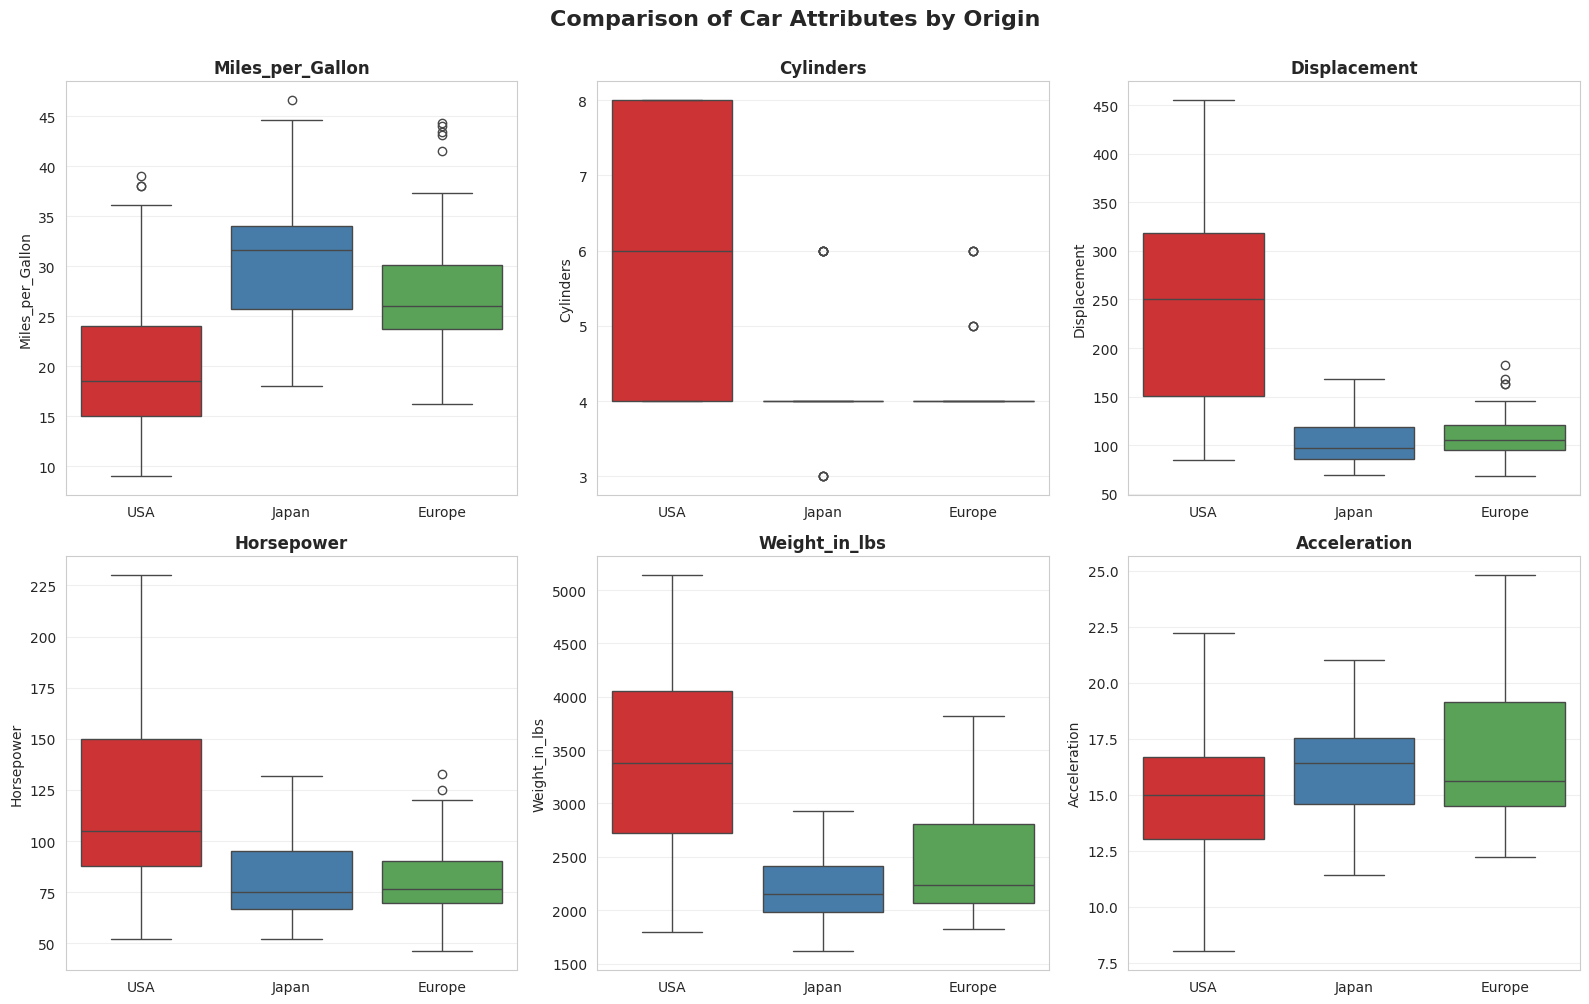

In [13]:
# Create comparison plots for key variables
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    plot_data = pd.DataFrame({
        col: cars_clean[col],
        'Origin': origin_groups
    })
    
    sns.boxplot(data=plot_data, x='Origin', y=col, ax=axes[idx], palette='Set1')
    axes[idx].set_title(col, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Comparison of Car Attributes by Origin', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Summary Statistics by Origin

In [14]:
# Calculate mean values by origin
summary_by_origin = cars_clean.groupby('Origin')[numeric_cols].mean()

print("Mean values by origin:")
summary_by_origin.round(2)

Mean values by origin:


,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration
Origin,,,,,,
Europe,27.60,4.16,109.63,80.56,2433.47,16.79
Japan,30.45,4.10,102.71,79.84,2221.23,16.17
USA,20.03,6.28,247.51,119.05,3372.49,14.99


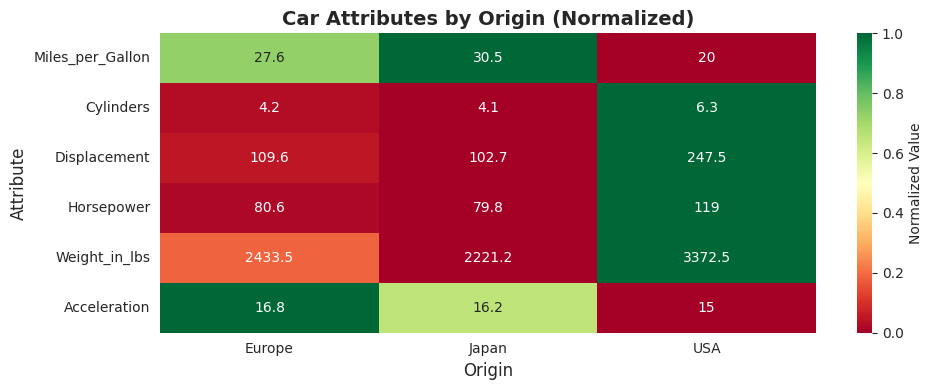

In [15]:
# Create a heatmap of mean values
fig, ax = plt.subplots(figsize=(10, 4))

# Normalize by column for better visualization
summary_normalized = (summary_by_origin - summary_by_origin.min()) / (summary_by_origin.max() - summary_by_origin.min())

sns.heatmap(summary_normalized.T, annot=summary_by_origin.T.round(1), 
            fmt='g', cmap='RdYlGn', ax=ax, cbar_kws={'label': 'Normalized Value'})

ax.set_title('Car Attributes by Origin (Normalized)', fontsize=14, fontweight='bold')
ax.set_xlabel('Origin', fontsize=12)
ax.set_ylabel('Attribute', fontsize=12)

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:
1. Loading and cleaning multivariate data
2. Exploratory correlation analysis
3. PCA with biplots and variance decomposition
4. NMDS ordination
5. PERMANOVA testing for group differences
6. Comparative visualization across groups

Key findings:
- Strong correlations between weight, displacement, cylinders, and horsepower
- Negative correlation between MPG and car size/power metrics
- Clear separation of cars by origin in ordination space
- Significant differences between origins confirmed by PERMANOVA
- European and Japanese cars tend to be smaller and more fuel-efficient
- American cars tend to be larger with more powerful engines